In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from IPython.display import HTML

import torch
from torch.utils.data import Dataset, dataloader
import torch.nn.functional as F
from torchsummary import summary

import sys
sys.path.append('../src')

from datagen import DataGen

### Creating rotating dataset

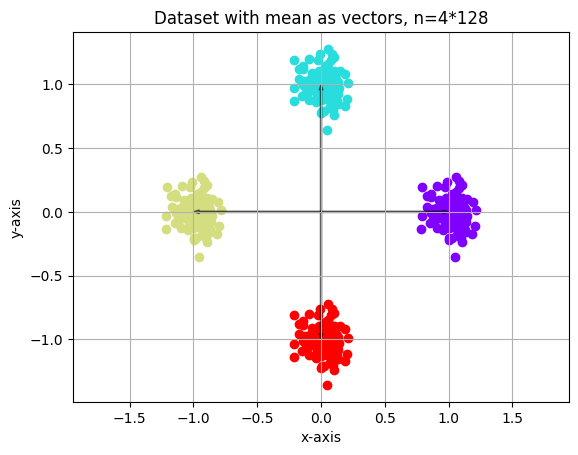

(512, 2)

In [9]:
n_clusters = 4
n_p = 128


# sym, as, as_extra, parallel, manual
datatype = "manual"
as_pos = np.array([[1,0],[0,1],[-1,0],[0,-1]])
dataclass = DataGen(n_clusters, n_p, scale=1, name=datatype, seed=1234, as_pos=as_pos)
centers,data,labels = dataclass.centers,dataclass.data,dataclass.labels

dataclass.plot()

data.shape

#### Rotating

In [49]:
ts = torch.arange(0, 1, 1/120)
rotdata = torch.zeros((data.shape[0],ts.shape[0],data.shape[1]))

data = torch.tensor(data, dtype=torch.float)
for t,ti in zip(ts,range(ts.shape[0])):
    rotmatrix = torch.tensor([[torch.cos(t*2*np.pi), -torch.sin(t*2*np.pi)],[torch.sin(t*2*np.pi), torch.cos(t*2*np.pi)]])
    rotdata[:,ti,:] = data@rotmatrix.T

C:\Users\matti\AppData\Local\Temp\ipykernel_7332\3272731779.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float)


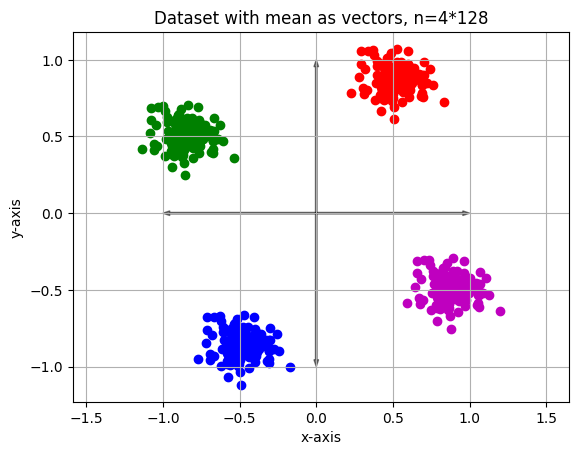

In [68]:
def plot_data(n_categories,n_p,data,centers):
    color_atlas = ["r","g","b","m","c","y","orange","brown","lime"]
    colors = []
    for i in range(n_categories):
        colors.append(color_atlas[i])

    for col,center,i in zip(colors,centers,range(n_categories)):
        plt.scatter(data[i*n_p:(i+1)*n_p,0],data[i*n_p:(i+1)*n_p,1],color=col)
        plt.arrow(0,0,center[0],center[1],length_includes_head=True,width=0.01,color=(0,0,0,0.5))

    plt.title(f"Dataset with mean as vectors, n={n_categories}*{n_p}")
    plt.axis("equal")
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    plt.grid("on")
    plt.show()

plot_data(n_clusters,n_p,rotdata[:,20,:].numpy(),centers)

### Putting data in torch dataset

In [61]:
class RotScatterData(Dataset):
    def __init__(self,time_pos_points,labels,n_cat):
        self.x = torch.tensor(time_pos_points).float()
        self.y = torch.tensor(labels).to(int)
        self.y = F.one_hot(self.y, num_classes=n_cat).double()
    def __len__(self): 
        return self.x.shape[0]
    def __getitem__(self, ixit):
        return self.x[ixit], self.y[ixit[0]]

In [62]:
BATCH_SIZE = 32

training_data = RotScatterData(rotdata,labels,n_clusters)
training_loader = torch.utils.data.DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

C:\Users\matti\AppData\Local\Temp\ipykernel_7332\2006605042.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(time_pos_points).float()


In [77]:
training_data[300,10]

(tensor([-0.9122, -0.3659]), tensor([0., 0., 1., 0.], dtype=torch.float64))